In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles, get_rotation_matrix
from calovi import WallModel
from binning import wall_neglible_at, transform_coords_df
from plots import *

In [2]:
col_widths

{'beamer': 307.28987, 'full': 468.3323, 'margin': 144, 'paper': 312}

In [3]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])
add_angles(-np.pi, -0.00001)

3.1415826535897935

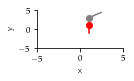

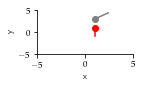

In [4]:
def plot_grid(p1, p2, traj1, traj2, ax):
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-5, 5)
    ax.set_ybound(-5, 5)
    

    ax.set_xlabel("x")
    ax.set_ylabel("y")
 
wf = {'margin': 1.0,
     'beamer': 0.5}

for target in ['margin', 'beamer']:
    fig, ax = plt.subplots(figsize=get_figsize(col_widths[target], wf=wf[target]))
    pos1, pos2 = np.array([1,1]), np.array([1,3])
    ang1, ang2 = np.deg2rad([-90, 45])
    traj1, traj2 = angled_vector(ang1) * 2, angled_vector(ang2) * 2

    plot_grid(pos1, pos2, traj1, traj2, ax)
    sns.despine(fig, ax)

    fig.tight_layout()
    fig.savefig(f'../../figures/receptive_field_before_{target}.pdf', transparent=True)

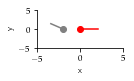

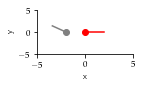

In [5]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
pos2_rot -= pos1_rot
pos1_rot = np.array([0.0, 0.0])
ang1_rot = 0.0
ang2_rot = sub_angles(ang2,ang1)
# 3. Plot
for target in ['margin', 'beamer']:
    fig, ax = plt.subplots(figsize=get_figsize(col_widths[target], wf=wf[target]))
    plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot, ax)

    sns.despine(fig, ax)
    fig.tight_layout()

    fig.savefig(f'../../figures/receptive_field_after_{target}.pdf', transparent=True)

[ 2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 52 53 58
 59 60 61] 
 [   6    1    9    5    5    1   15   27   12    3    6    4    1   14
   40  272  226   56    9    5   17   57  491 7460 5550  366   20   13
   16   27  524 6014 8002  413   32    7   10    8   25  183  225   79
    5    7    9   19    7    6    3   10    2]


(473.8125, 1645.7143288990803, 51)

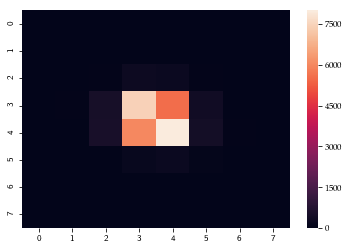

In [34]:
def analyze_bins(df):
    bins, counts = np.unique(df['bin'], return_counts=True)
    print(bins,'\n', counts)

    # Include zero bins
    #bins_complete = np.zeros((num_bins+1, num_bins+1))
    #x_bins, y_bins = bins % num_bins, bins // num_bins
    #x_bins
    bins_complete = np.zeros((num_bins)**2)
    bins_complete[bins] = counts
    bins_complete = bins_complete.reshape((num_bins, num_bins))
    sns.heatmap(bins_complete)
    return bins_complete.mean(), bins_complete.std(), len(bins)
analyze_bins(df_test)

In [6]:
df_rf_te = pd.read_csv('../../data/processed/rf_test.csv')
df_rf_tr = pd.read_csv('../../data/processed/rf_train.csv')

#df_rf_tr = df_rf_tr[df_rf_tr['dt'] == 0]
#df_rf_te = df_rf_te[df_rf_te['dt'] == 0]

In [7]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')
df_kicks_te = pd.read_csv('../../data/processed/kicks_guy_test.csv')
df_rf_tr.shape, df_rf_te.shape, (df_train['dt'] == 0).sum()

NameError: name 'df_train' is not defined

In [286]:
with open('../../models/calovi_wall.model', mode='rb') as f:
    wall_model = pickle.load(f)

cutoff_wall_range = binning.wall_neglible_at(wall_model)
print(cutoff_wall_range)

df_train = transform_coords_df(df_kicks_tr.copy(), cutoff_wall_range=cutoff_wall_range)
df_test = transform_coords_df(df_kicks_te.copy(), cutoff_wall_range=cutoff_wall_range) 

#df_train = df_train[df_train['dt'] == 0]
#df_test = df_test[df_test['dt'] == 0]

4.812479587209935


In [287]:
bins = binning.get_bins_static(df_train, num_bins=8, ignore_outliers=False)

13.895965569140376


In [288]:
def digitize_df_static(df, bins, num_bins, closed_interval=True):
    # TODO: Open intervals on both sides!
    bin_x = np.digitize(df['x_f1'], bins=bins) - 1
    bin_y = np.digitize(df['y_f1'], bins=bins) - 1
    
    print('Before clipping', bin_x.min(), bin_y.min(), bin_x.max(), bin_y.max())
    # Clip to range
    bin_x = bin_x.clip(0, num_bins-1)
    bin_y = bin_y.clip(0, num_bins-1)
    print('After clipping', bin_x.min(), bin_y.min(), bin_x.max(), bin_y.max())

    print(bin_x.min(), bin_x.max(), bin_y.max())
    
    bin = (bin_x*num_bins) + bin_y
    if closed_interval:
        # Fish outside range have bin -1
        bin[(df['x_f1'] <= bins.min()) | (df['y_f1'] <= bins.min()) |
           (df['x_f1'] >= bins.max()) | (df['y_f1'] >= bins.max())] = -1
    
    return bin
bins_static_tr = digitize_df_static(df_train,bins,8, closed_interval=False)
bins_static_te = digitize_df_static(df_test,bins,8, closed_interval=False)

Before clipping 0 0 7 7
After clipping 0 0 7 7
0 7 7
Before clipping 0 -1 7 8
After clipping 0 0 7 7
0 7 7


In [10]:
def print_statistic(bins):
    bins, counts = np.unique(bins, return_counts=True)
    total_counts = np.zeros(64)
    total_counts[bins] = counts
    print(total_counts.mean(), total_counts.std(), len(total_counts) - len(counts))
    
#print_statistic(bins_static_tr), print_statistic(bins_static_te);

NameError: name 'bins_static' is not defined

In [19]:
import dill as pickle
import binning
with open('../../models/adaptive_bins.model', 'rb') as file:
    edges = pickle.load(file)

edges_x, edges_y, num_bins = edges['edges_x'], edges['edges_y'], edges['num_bins']

edges_x.shape ,edges_y.shape

# Reverse one hot encoding of receptive field file!
features = [f'feature_{i}' for i in range(64)]
bins = df_rf_te[features].idxmax(axis=1).values
bins = np.array([int(b.split('_')[1]) for b in bins])
weights = np.unique(bins, return_counts=True)[1]#.reshape(8,8)[1:-1,:].reshape(-1)
print_statistic(bins)

554.5 162.35426157018486 0


842 224
842 224


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


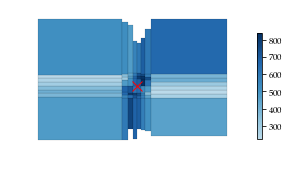

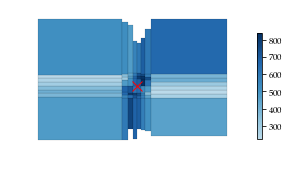

In [21]:
from matplotlib import cm
from matplotlib.colors import Normalize


# See: https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib/20146989#20146989
class DivergentNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)
        print(self.vmax, self.vmin)
        
    def __call__(self, value, clip=None):
        x, y = [self.vmin, 0.0, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_bins(edges_x, edges_y, weights=None, weights_range=None,
              fig=None, ax=None, xlim=[-15,15], ylim=[-15,15]):
    nun_bins = len(edges_x) - 1
    edge_x_sizes = np.ediff1d(edges_x)

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(20,20))        
    
    if weights is None:
        color = lambda x: 'white'
    else:
        if weights_range is None:
            vmin, vmax = weights.min(), weights.max()
        else:
            vmin, vmax = weights_range
        norm = DivergentNormalize(vmin=vmin, vmax=vmax)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)
        mapper.set_array(weights)
        def color(x):
            w = weights[x]
            return mapper.to_rgba(w)
        
    for i, edge_x in enumerate(edges_x[:-1]):
        cur_y_edges = edges_y[i, :]
        cur_edge_y_sizes = np.ediff1d(cur_y_edges)    
        for j, edge_y in enumerate(cur_y_edges[:-1]):
            ax.add_patch(
                patches.Rectangle(
                (edge_x, edge_y),
                edge_x_sizes[i],
                cur_edge_y_sizes[j],
                fill=True,
                facecolor=color(i*num_bins + j),
                edgecolor='black',
                linewidth=0.1))

    # TODO: Don't hardcore!
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(0,0, c='red', s=100, marker='x', zorder=10, linewidth=1)
    ax.axis('off')
    
    if weights is not None:
        return mapper # for colorbar 

for target in ['paper', 'beamer']:
    fig, ax = plt.subplots(figsize=get_figsize(col_widths['paper']))
    mapper = plot_bins(edges_x,
                       edges_y,
                       weights=weights,
                       fig=fig,
                       ax=ax)
    #fig.set_size_inches(5,5)
    fig.colorbar(mapper, shrink=0.7)
    fig.set_tight_layout(True)
    fig.savefig(f'../../figures/rf_occupancy_test_{target}.pdf', transparent=True)

842 224
842 224
842 224


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


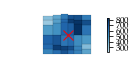

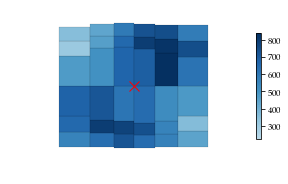

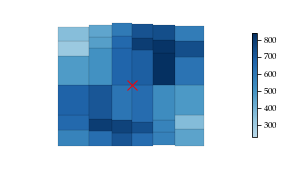

In [46]:
def plot_bins(edges_x, edges_y, weights=None, weights_range=None,
              fig=None, ax=None, xlim=[-15,15], ylim=[-15,15], offset=0):
    nun_bins = len(edges_x) - 1
    edge_x_sizes = np.ediff1d(edges_x)

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(20,20))        
    
    if weights is None:
        color = lambda x: 'white'
    else:
        if weights_range is None:
            vmin, vmax = weights.min(), weights.max()
        else:
            vmin, vmax = weights_range
        norm = DivergentNormalize(vmin=vmin, vmax=vmax)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)
        mapper.set_array(weights)
        def color(x):
            w = weights[x]
            return mapper.to_rgba(w)
        
    for i, edge_x in enumerate(edges_x[:-1]):
        cur_y_edges = edges_y[i, :]
        cur_edge_y_sizes = np.ediff1d(cur_y_edges)    
        for j, edge_y in enumerate(cur_y_edges[:-1]):
            ax.add_patch(
                patches.Rectangle(
                (edge_x, edge_y),
                edge_x_sizes[i],
                cur_edge_y_sizes[j],
                fill=True,
                facecolor=color((i+offset)*num_bins + (j+offset)),
                edgecolor='black',
                linewidth=0.1))

    # TODO: Don't hardcore!
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(0,0, c='red', s=100, marker='x', zorder=10, linewidth=1)
    ax.axis('off')
    
    if weights is not None:
        return mapper # for colorbar 

edges_x_small = edges_x[1:-1]
edges_y_small = edges_y[1:-1, 1:-1]
weights_small = weights

for target in ['margin', 'paper', 'beamer']:
    fig, ax = plt.subplots(figsize=get_figsize(col_widths[target]))
    mapper = plot_bins(edges_x_small,
                       edges_y_small,
                       weights=weights_small,
                       fig=fig,
                       ax=ax,
                       xlim=[-3,3],
                       ylim=[-3,3],
                      offset=1,
                      weights_range=(weights.min(), weights.max()))
    #fig.set_size_inches(5,5)
    fig.colorbar(mapper, shrink=0.7)
    fig.set_tight_layout(True)
    fig.savefig(f'../../figures/rf_occupancy_test_zoomed_{target}.pdf', transparent=True)